# Reconcile company names from CapitalIQ database and EMIS database.
This notebook include all the processing steps of getting data from CapitalIQ and EMIS ready for cross-reference. We want to find people in EMIS (the table "CompanyShareholders") and find companies and equity they own. Then, we find financial information corresponding to those companies from CapitalIQ (the table "Company"). There are several problems.
1. The Shareholders contain companies. We need to decide whether a shareholder is human or not.
2. The two datasets have different conventions in naming company names. For example, company names in CapitalIQ have many characters different from alphabet and number (accented or some special symbols); company names in EMIS have only alphabets and numbers and some signs.
3. The Shareholder names in EMIS have characters different from alphabets and numbers.
To solve this problem, I need to create unique identifiers for companies so that they can be cross-referenced. The long goal is following.

Step 1, calculate net worth from people with comprehensive information (defined in "6-factors model"). Those data are treated as "ground truth" for training.

Step 2, use those "ground truth" to train an regression model (the regressors don't need to be restricted within information used to calculate those ground truth samples).

Step 3, identify those predictors having the most predictive power and then filter the database to generate samples having those information and do the prediction.

Step 4, this process really needs an iterative development and validation, but this would be extremely fun and full of excitement. I can image this would be the first model of such kind in this application. Of course, I need to read some textbooks and papers to find out relevant tools.

## Read data from database

In [1]:
import sqlite3
# Build connection with SQLlite
FW_conn = sqlite3.connect('../Database/FocalWealth_20180217.db')

In [2]:
# Initialize a cursor and don't change the database
# https://docs.python.org/2/library/sqlite3.html
FW_cursor = FW_conn.cursor()
# Example (the execute method should be treated as an iterator)
for res in FW_cursor.execute('select count(*) from Company'):
    print res

(77369,)


In [3]:
# Read data from the CompanyShareholders table to pandas dataframe
import pandas as pd
df_perc_owned = pd.read_sql_query("""
    select * from CompanyShareholders where PercentageOwned is not null;""", FW_conn)

print "The the first 5 lines of percentage owned in the CompanyShareholders table with not null PercentageOwned"
print(df_perc_owned[:5])

The the first 5 lines of percentage owned in the CompanyShareholders table with not null PercentageOwned
                                        Shareholders  \
0  Manaca S.A. Armazens Gerais e Administracao (9...   
1                      Jose Carlos Librelato (0.10%)   
2                            Aloir Librelato (0.10%)   
3                           Gilmar Librelato (0.10%)   
4              Edp Energias Do Brasil S.A. (100.00%)   

                       Company PercentageOwned  
0  Clarion S.A. Agroindustrial          99.79%  
1               Librelato S.A.           0.10%  
2               Librelato S.A.           0.10%  
3               Librelato S.A.           0.10%  
4                Energest S.A.         100.00%  


In [4]:
# Some preprocess for data columns. Extract Shareholder names and equity percentage. 
import re
df_perc_owned["Shareholders_Name"] = [re.findall('^(.+)[\s]*\({1}',sh)[0] for sh in df_perc_owned["Shareholders"]]
df_perc_owned["PercentageOwned_Num"] = [float(re.findall('(.+)%',sh)[0]) for sh in df_perc_owned["PercentageOwned"]]
print(df_perc_owned[:5])

                                        Shareholders  \
0  Manaca S.A. Armazens Gerais e Administracao (9...   
1                      Jose Carlos Librelato (0.10%)   
2                            Aloir Librelato (0.10%)   
3                           Gilmar Librelato (0.10%)   
4              Edp Energias Do Brasil S.A. (100.00%)   

                       Company PercentageOwned  \
0  Clarion S.A. Agroindustrial          99.79%   
1               Librelato S.A.           0.10%   
2               Librelato S.A.           0.10%   
3               Librelato S.A.           0.10%   
4                Energest S.A.         100.00%   

                              Shareholders_Name  PercentageOwned_Num  
0  Manaca S.A. Armazens Gerais e Administracao                 99.79  
1                        Jose Carlos Librelato                  0.10  
2                              Aloir Librelato                  0.10  
3                             Gilmar Librelato                  0.10  
4      

In [5]:
# A breif summary of equity share
import numpy as np
print("Average and standard deviation: %s; %s." % 
      (np.mean(df_perc_owned["PercentageOwned_Num"]),np.std(df_perc_owned["PercentageOwned_Num"])))

Average and standard deviation: 40.9758813906; 36.9717069326.


## Get CompanyName, ExchangeTicker, SecurityTickers, PrimarySector, CompanyType, CompanyStages, EBITDA, TotalRevenue, TotalEnterpriseValue, MarketCapitalization, StockBasedComp, CompensationAndBenefits, TotalCashandSTInvestments, ShortTermInvestments, LongTermInvestments, TotalInvestments from the Company table.

In [6]:
# Read data from the Company table to pandas dataframe
import pandas as pd
df_comp_info = pd.read_sql_query("""
    select CompanyName, ExchangeTicker, SecurityTickers, PrimarySector, CompanyType, CompanyStages, EBITDA, TotalRevenue, 
    TotalEnterpriseValue, MarketCapitalization, StockBasedComp, CompensationAndBenefits, 
    TotalCashandSTInvestments, ShortTermInvestments, LongTermInvestments, TotalInvestments
    from Company 
    where TotalRevenue is not null or
    TotalEnterpriseValue is not null;""", FW_conn)
print("The the first 5 lines of financial information in the Company table with not null TotalRevenue")
print(df_comp_info[:5])

The the first 5 lines of financial information in the Company table with not null TotalRevenue
                             CompanyName ExchangeTicker SecurityTickers  \
0                   Construtora Nm Ltda.           None            None   
1    Construtora Norberto Odebrecht S.A.           None            None   
2                   Construtora OAS S.A.           None            None   
3           Construtora Passarelli Ltda.           None            None   
4  Construtora Paulo Taufik Camasmie S/A           None            None   

            PrimarySector      CompanyType CompanyStages  EBITDA  \
0             Industrials  Private Company          None     NaN   
1             Industrials  Private Company          None -543.40   
2             Industrials  Private Company          None -382.50   
3             Industrials  Private Company          None    2.66   
4  Consumer Discretionary  Private Company          None     NaN   

   TotalRevenue  TotalEnterpriseValue  Market

In [7]:
# Remove the accented alphabets in the company name in the "Company" Table (CapitalIQ data) and turn them into lowercase
import unidecode
df_comp_info["CompanyName_Unaccented"] = [unidecode.unidecode(name).lower() for name in df_comp_info["CompanyName"]]
# Remove the accented alphabets in the shareholder name in the "CompanyShareholders" Table (EMIS data) and turn them into lowercase
df_perc_owned["Shareholders_Name_Unaccented"] = [unidecode.unidecode(name).lower() for name in df_perc_owned["Shareholders_Name"]]
# Transfer the Company Name of EMIS data from unicode to ascii for later string comparison and turn them into lowercase
df_perc_owned["CompanyName_Lower"] = [unidecode.unidecode(name).lower() for name in df_perc_owned["Company"]] 
# Actually, this doesn't matter because the same string in unicode and ascii are the same. 
# Here, we transfer to ascii anyway for consistency.

In [8]:
# The pattern for non-alphanumeric characters are coming from Jupyter Notebook ExperimentRegression
patt_non_alphanum = r'[\.\&/:,\'\"\-;\\+=\#`!?>\|\_]' 
# Note that have to add escape sign before '-', o.w. it is interpreted as a range symbol and as a result, numbers are ignored

def Normalize_Name(patt_non_alphanum, target_df, source_col_name, target_col_name, include_parenth=False):
    """Normalize names by decoding accented alphabet, replacing non-alphabetnumeric characters with
    white space, and spliting based on white space. A tag to mark whether include info in parenthesis."""
    target_df[target_col_name]=""
    for idx,name in enumerate(target_df[source_col_name]):
        comp_name = name
        normalized_list = []
        para_ele = re.findall(r'[\(\[](.+)[\)\]]',comp_name)# Extract inside () or []
        if para_ele:
            comp_name = re.sub(r'\(.+\)', ' ', comp_name)
            if include_parenth:
                para_ele = [y for x in para_ele for y in re.sub(patt_non_alphanum,' ', x).split()]# Flatten a list of lists
                normalized_list.extend(para_ele)
        sa_ele = re.findall(r's[\./]{1}a[\.]?',comp_name)# Extract "s.a." or "s/a", and put "s.a." back in the string.
        if sa_ele:
            for _ in range(len(sa_ele)):
                normalized_list.append('s.a.')
            comp_name = re.sub(r's[\./]{1}a[\.]?', ' ', comp_name)
        ltd_ele = re.findall(r'ltd[a]?[.]?',comp_name)# Extract "ltda." or "ltda" or "ltd"; and put "ltd" back in the string.
        if ltd_ele:
            for _ in range(len(ltd_ele)):
                normalized_list.append('ltd')
            comp_name = re.sub(r'ltd[a]?[.]?', ' ', comp_name)

        comp_name = re.sub(patt_non_alphanum,' ', comp_name)
        normalized_list.extend(comp_name.split())
        print idx, normalized_list, comp_name.split()
        normalized_list.sort()
        target_df.at[idx, target_col_name]= ' '.join(normalized_list)

In [9]:
# Split company name based on non-alphanumeric sets
# Table from CapitalIQ
Normalize_Name(patt_non_alphanum,df_comp_info,"CompanyName_Unaccented","Company_Name_Normalized",False)

# Split company name based on non-alphanumeric sets
# Table from EMIS
Normalize_Name(patt_non_alphanum,df_perc_owned,"CompanyName_Lower","Company_Name_Normalized",False)

# Split shareholders name based on non-alphanumeric sets
# Table from EMIS
Normalize_Name(patt_non_alphanum,df_perc_owned,"Shareholders_Name_Unaccented","Shareholders_Name_Normalized",False)

0 ['ltd', 'construtora', 'nm'] ['construtora', 'nm']
1 ['s.a.', 'construtora', 'norberto', 'odebrecht'] ['construtora', 'norberto', 'odebrecht']
2 ['s.a.', 'construtora', 'oas'] ['construtora', 'oas']
3 ['ltd', 'construtora', 'passarelli'] ['construtora', 'passarelli']
4 ['s.a.', 'construtora', 'paulo', 'taufik', 'camasmie'] ['construtora', 'paulo', 'taufik', 'camasmie']
5 ['ltd', 'construtora', 'pelotense'] ['construtora', 'pelotense']
6 ['ltd', 'construtora', 'phoenix'] ['construtora', 'phoenix']
7 ['ltd', 'construtora', 'premold'] ['construtora', 'premold']
8 ['s.a.', 'construtora', 'presidente'] ['construtora', 'presidente']
9 ['s.a.', 'construtora', 'quebec'] ['construtora', 'quebec']
10 ['s.a.', 'construtora', 'queiroz', 'galvao'] ['construtora', 'queiroz', 'galvao']
11 ['ltd', 'construtora', 'remo'] ['construtora', 'remo']
12 ['ltd', 'construtora', 'ribeiro', 'caram'] ['construtora', 'ribeiro', 'caram']
13 ['s.a.', 'construtora', 'sagendra'] ['construtora', 'sagendra']
14 ['s.a.

## Check if a shareholder is a company or not

In [20]:
# Check how many samples are Human based on preliminary standards (whether contains s.a. or ltd)
comp_name_set = set(df_perc_owned["Company_Name_Normalized"]) | set(df_comp_info["Company_Name_Normalized"])
df_perc_owned["Shareholder_Is_Human"]=""
count = 0
for idx, sh in enumerate(df_perc_owned["Shareholders_Name_Normalized"]):
    if re.findall(r's\.a\.|\bltd\b',sh) or sh in comp_name_set:
        df_perc_owned.at[idx,"Shareholder_Is_Human"] = False
    else:
        df_perc_owned.at[idx,"Shareholder_Is_Human"] = True
        count += 1
print count        


2818


In [21]:
# Check how many samples are Human and the companies he/she own are in the CapitalIQ database
CIQ_comp_name_set = set(df_comp_info["Company_Name_Normalized"])
count = 0
for idx, sh in enumerate(df_perc_owned["Shareholders_Name_Normalized"]):
    if df_perc_owned["Shareholder_Is_Human"][idx] and df_perc_owned["Company_Name_Normalized"][idx] in CIQ_comp_name_set:
        count += 1
print count 

1599


## Translate the column Shareholders_Name to English so that I can have a good judgement on what words indicate that this is a company not a human

In [14]:
# Translate Portuguese to English to see what are words to decide a name is a company not a human 
from googletrans import Translator
translator = Translator()

for idx, name in enumerate(df_perc_owned["Shareholders_Name"].sample(500)):
    print("Index: %s; Shareholder Name: %s; Translation: %s" % (idx, name, translator.translate(name).text))


Index: 0; Shareholder Name:  Flavia Bettanin ; Translation: Flavia Bettanin
Index: 1; Shareholder Name: Roseli de Fatima dos Passos Tortelli ; Translation: Roseli de Fatima dos Passos Tortelli
Index: 2; Shareholder Name: Deutsche Bank S.A. - Banco Alemao ; Translation: Deutsche Bank S.A. - Banco Alemao
Index: 3; Shareholder Name: Vli Multimodal S.A. ; Translation: Multimodal SA
Index: 4; Shareholder Name: Arcelor Brasil S.A. ; Translation: Arcelor Brasil S.A.
Index: 5; Shareholder Name: Localiza Rent A Car S.A. ; Translation: Localiza Rent A Car S.A.
Index: 6; Shareholder Name: Francisco De Assis Veras Fortes ; Translation: Francisco De Assis Veras Fortes
Index: 7; Shareholder Name:  Accenture Minority III Ltd ; Translation: Accenture Minority III Ltd
Index: 8; Shareholder Name:  Atmos Capital GestÃo de Recursos Ltda ; Translation: Atmos Capital GestÃo de Recursos Ltda
Index: 9; Shareholder Name:  Priscilla Tristao Joho ; Translation: Priscilla Tristao Joho
Index: 10; Shareholder Name:

In [12]:
# Go through the first 500 samples of shareholder names in Portuguese and English and see what words can be
# used to check if a shareholder name is from a human or a company. The keywords set are below.
keyword_detect_company = ['Company', 'Limited', 'Banque', 'Fundo', 'Partners', 'Prtners', 'Inv', 'Investimento',
                                 'Investimentos', 'Banco', 'Bank', 'Corporate', 'Grupo', 'Prefeitura', 'SARL', 'Municipio',
                                 'Petrobras', 'Associacao', 'Assoc', 'Part', 'capital', 'Treasury','LLC', 'Corporation',
                                 'Parts', 'Companhia', 'Cia', 'Overseas', 'Holding', 'Agric', 'Governo', 'Sec', 'Secretaria',
                                 'Group', 'Estado', 'Investors', 'Asset', 'Empresa', 'Income', 'Brasil', 'Participacoes',
                         'Brasil', 'Recuperacao', 'Judicial', 'credit', 'Desenvolvimento', 'multi', 'Multiestrategia',
                         'Brazilian', 'Logistica', 'Latina', 'America', 'Servico', 'Garantia', 'Tempo', 'Depositario',
                         'Commodities', 'Eletricidade', 'Servs', 'Energia', 'Global', 'Infra', 'Road', 'Economica',
                         'Financiamento', 'Transmissora', 'Eletrica', 'Hospitalares', 'Clinicas', 'Accenture', 'Beneficente',
                         'Shares', 'Services', 'Motorola','Motors','Holdings','Financial', 'Holding', 'Eletricas', 'Federal',
                         'Steel', 'offshores', 'International', 'Mining', 'Resources', 'Economicos', 'Recursos', 'Time', 'world',
                         'video', 'Finance', 'Intl', 'Petroleo', 'Solar', 'Cidade', 'Comercial', 'centrais', 'Seguros', 'fund',
                         'gas','General', 'Mercantille', 'Infraestrutura', 'Mgmt', 'Representacoes', 'Markets', 'Telecom',
                         'co', 'inc', 'Standard', 'Seguranca', 'Solucoes', 'Zurich', 'Pagamento', 'Identificacao', 'Airport',
                         'Industria', 'Material', 'Funcionarios', 'Social', 'Agencia', 'TRANSPORT', 'Nacional', 'Securitaria',
                         'Medicamentos', 'Distribuicao', 'Geografica', 'Produtos', 'Farmaceuticos', 'Civil', 'Auto', 'Tecnologia',
                         'corp', 'Trust', 'Management', 'Assurances', 'Producers', 'Alcool', 'Brazil', 'limitada',
                         'tecidos', 'Educacional', 'Sociedade', 'Positivo', 'life', 'investment', 'gmbh', 'automoveis', 'Usina',
                         'Telecomunicacoes', 'Leasing', 'Settlement', 'Empreendimentos', 'Incorporated', 'Empreed', 'Motores',
                         'Departamento', 'Fundacao', 'Industriais', 'Transportes', 'Engenharia', 'Industrial', 'Tesouraria',
                         'llp', 'Participaciones', 'Fertilizer', 'Funds', 'ind', 'foods', 'Municipalities', 'Lp',
                         'Desenv', 'Consulting', 'Fundos', 'Fdo']
# Take 'Familia', 'Sales' out, because 'Familia' is the family business; and 'Sales' is one of family names in Brazil and
# people with this family name is likely to have very high net worth.
keyword_bankrupted = 'Em Recuperacao Judicial' # Bankrupted in English

In [13]:
keyword_detect_company = [word.lower() for word in keyword_detect_company]
keyword_detect_company.sort()
print keyword_detect_company

['accenture', 'agencia', 'agric', 'airport', 'alcool', 'america', 'asset', 'assoc', 'associacao', 'assurances', 'auto', 'automoveis', 'banco', 'bank', 'banque', 'beneficente', 'brasil', 'brasil', 'brazil', 'brazilian', 'capital', 'centrais', 'cia', 'cidade', 'civil', 'clinicas', 'co', 'comercial', 'commodities', 'companhia', 'company', 'consulting', 'corp', 'corporate', 'corporation', 'credit', 'departamento', 'depositario', 'desenv', 'desenvolvimento', 'distribuicao', 'economica', 'economicos', 'educacional', 'eletrica', 'eletricas', 'eletricidade', 'empreed', 'empreendimentos', 'empresa', 'energia', 'engenharia', 'estado', 'farmaceuticos', 'fdo', 'federal', 'fertilizer', 'finance', 'financial', 'financiamento', 'foods', 'funcionarios', 'fund', 'fundacao', 'fundo', 'fundos', 'funds', 'garantia', 'gas', 'general', 'geografica', 'global', 'gmbh', 'governo', 'group', 'grupo', 'holding', 'holding', 'holdings', 'hospitalares', 'identificacao', 'inc', 'income', 'incorporated', 'ind', 'indus

In [14]:
# Incoporate English and Portuguese translations of those keywords and expand the size of keywords set
from googletrans import Translator
translator = Translator()
keyword_detect_company_en = []
keyword_detect_company_pt = []
for keyword in keyword_detect_company:
    keyword_en = unidecode.unidecode(translator.translate(keyword, src='pt', dest='en').text.lower())
    keyword_detect_company_en.append(keyword_en)
    keyword_pt = unidecode.unidecode(translator.translate(keyword, src='en', dest='pt').text.lower())
    keyword_detect_company_pt.append(keyword_pt)
    #print("Keyword: %s; Translation en: %s; Translation pt: %s" % (keyword, keyword_en, keyword_pt))

keyword_detect_company_set = set(keyword_detect_company) | set(keyword_detect_company_en) | set(keyword_detect_company_pt)
keyword_detect_company_set

{'accenture',
 'acentuar',
 'aco',
 'aeroporto',
 'agencia',
 'agency',
 'agric',
 'agricultural',
 'airport',
 'alcohol',
 'alcool',
 'alimentos',
 'america',
 'assentamento',
 'asset',
 'assoc',
 'associacao',
 'association',
 'assurances',
 'auto',
 'automobiles',
 'automoveis',
 'banco',
 'bank',
 'banque',
 'beneficent',
 'beneficente',
 'benefico',
 'bottom',
 'brasil',
 'brasileiro',
 'brazil',
 'brazilian',
 'capital',
 'centrais',
 'central',
 'cia',
 'cidade',
 'city',
 'civil',
 'clinicas',
 'clinics',
 'co',
 'comercial',
 'commercial',
 'commodities',
 'companhia',
 'company',
 'compartilha',
 'confiar em',
 'consultando',
 'consulting',
 'corp',
 'corporacao',
 'corporate',
 'corporation',
 'corporativo',
 'county',
 'credit',
 'credito',
 'de ativos',
 'departamento',
 'department',
 'depositario',
 'depositary',
 'desenv',
 'desenvolvimento',
 'development',
 'did you work',
 'distribuicao',
 'distribution',
 'economic',
 'economica',
 'economicos',
 'educacional',
 'ed

In [17]:
len(keyword_detect_company_set)

285

In [22]:
# Check if a shareholder name contain any word from keywords set
# Actually, those company names in the shareholder column have a large portion of funds or holding companies.
# We are interested in the people behind those holding companies because they are potential HNWIs. The reason that 
# CapitalIQ and EMIS doesn't include information in those companies is because CapitalIQ and EMIS are mainly used by
# investment banking who are interested in operating companies not people (so they can invest money into them).
# However, we are interested in family office, wealth management so that we are interested in those companies. And
# we can get shareholders for those holding or fund companies from Brazil IRF, because they have complete information.
# However, we don't know whether we can get those information from IRF. Remember those holding or fund companies
# would not show up in CapitalIQ and EMIS because they are not interested in those companies (but I can do a test on
# this to check if this is true).
for idx, name in enumerate(df_perc_owned["Shareholders_Name_Normalized"]):
    if df_perc_owned["Shareholder_Is_Human"][idx]:
        for keyword in keyword_detect_company_set:
            if re.findall(r'\b'+keyword+r'\b', name):
                print("Index: %s; Keyword: %s; Name: %s" % (idx, keyword, name))
                df_perc_owned.at[idx, "Shareholder_Is_Human"] = False
                break

df_perc_owned[df_perc_owned["Shareholder_Is_Human"]==True].shape

Index: 16; Keyword: limited; Name: company dislin limited
Index: 22; Keyword: part; Name: belsa e part
Index: 25; Keyword: banque; Name: banque generale societe
Index: 26; Keyword: participacoes; Name: de desenvolvimento em fundo iii investimento multiestrategia omega participacoes
Index: 27; Keyword: participacoes; Name: bjj de em fundo income investimento participacoes
Index: 29; Keyword: participacoes; Name: de em fundo investimento lambda3 multiestrategia participacoes
Index: 34; Keyword: brasil; Name: acoes brasil c fdo inv livre mutuo pv
Index: 35; Keyword: capital; Name: america capital cayman ii islan l latin p prtners
Index: 54; Keyword: garantia; Name: de de de do do fundo fundo garantia investimento servico tempo
Index: 55; Keyword: bank; Name: bank chase jpmorgan
Index: 70; Keyword: eletricidade; Name: caiua de eletricidade servs
Index: 73; Keyword: investment; Name: agricole and bank corporate credit investment
Index: 74; Keyword: global; Name: agricole and bank banking co

(1987, 10)

In [23]:
# Check how many company names in the EMIS shareholder name column is in the EMIS company name column
EMIS_comp_name_set = set(df_perc_owned["Company_Name_Normalized"])
count = 0
for idx, row in df_perc_owned.iterrows():
    if not row["Shareholder_Is_Human"] and row["Shareholders_Name_Normalized"] in EMIS_comp_name_set:
        print("The index: %s; The shareholder name: %s" % (idx, row["Shareholders_Name_Normalized"]))
        count += 1

print(("\nThe number of shareholder names which are also in the company name colum in EMIS data set: %s \n"
       "The portion of this number in the total shareholder names which are not human name: %s")
      % (count, 1.0*count/df_perc_owned[df_perc_owned["Shareholder_Is_Human"]==False].shape[0]))

The index: 4; The shareholder name: brasil do edp energias s.a.
The index: 6; The shareholder name: aguas ambiental brasil cab companhia de do
The index: 7; The shareholder name: em judicial oi recuperacao s.a.
The index: 11; The shareholder name: do fertilizantes fertipar limitada parana
The index: 14; The shareholder name: minerva s.a.
The index: 45; The shareholder name: cia do quente rio thermas
The index: 52; The shareholder name: all america latina logistica s.a.
The index: 53; The shareholder name: cosan limited
The index: 56; The shareholder name: bndes bndespar participacoes s.a.
The index: 57; The shareholder name: itau s.a. unibanco
The index: 58; The shareholder name: banco s.a. votorantim
The index: 59; The shareholder name: brasil commodities dreyfus louis s.a.
The index: 62; The shareholder name: minupar participacoes s.a.
The index: 63; The shareholder name: brookfield incorporacoes s.a.
The index: 71; The shareholder name: cpfl energia s.a.
The index: 83; The sharehold

In [24]:
# Check those shareholder names to see if they are really not company names
from googletrans import Translator
translator = Translator()
for idx, name in enumerate(df_perc_owned["Shareholders_Name"]):
    if df_perc_owned["Shareholder_Is_Human"][idx]:
        print("Index: %s; Shareholder Name: %s; Translation: %s" % (idx, name, translator.translate(name).text))

Index: 1; Shareholder Name: Jose Carlos Librelato ; Translation: Jose Carlos Librelato
Index: 2; Shareholder Name:  Aloir Librelato ; Translation: Aloir Librelato
Index: 3; Shareholder Name:  Gilmar Librelato ; Translation: Gilmar Librelato
Index: 9; Shareholder Name:  Jose Carlos de Souza ; Translation: Jose Carlos de Souza
Index: 10; Shareholder Name:  Maria Flavia Perilo Vieira e Souza ; Translation: Maria Flavia Perilo Vieira e Souza
Index: 13; Shareholder Name:  Paulo Sergio Roberto da Silva ; Translation: Paulo Sergio Roberto da Silva
Index: 17; Shareholder Name:  Ruth Gianesella Taurisano ; Translation: Ruth Gianesella Taurisano
Index: 19; Shareholder Name:  Espolio de Flavio Sa Brito Vianna ; Translation: Espolio de Flavio Sa Brito Vianna
Index: 20; Shareholder Name: Tiago Vidal Lohn ; Translation: Tiago Vidal Lohn
Index: 21; Shareholder Name: Ludovico Baltaazar Buchle ; Translation: Ludovico Baltaazar Buchle
Index: 23; Shareholder Name:  Paulo Hilario Buchle ; Translation: Pau

In [25]:
# Check how many samples are Human and the companies he/she own are in the CapitalIQ database or EMIS database
count = 0
for idx, sh in enumerate(df_perc_owned["Shareholders_Name_Normalized"]):
    if df_perc_owned["Shareholder_Is_Human"][idx] and df_perc_owned["Company_Name_Normalized"][idx] in comp_name_set:
        count += 1
print count 

1987


In [26]:
# Check how many samples are Human and the companies he/she own are in the CapitalIQ database
CIQ_comp_name_set = set(df_comp_info["Company_Name_Normalized"])
count = 0
CIQ_duplicate_comp_name_set = set([])
for idx, sh in enumerate(df_perc_owned["Shareholders_Name_Normalized"]):
    comp_normalized = df_perc_owned["Company_Name_Normalized"][idx]
    if (df_perc_owned["Shareholder_Is_Human"][idx]
        and comp_normalized in CIQ_comp_name_set):
        num_occu = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["TotalRevenue"].shape[0]
        if (num_occu > 1):
            CIQ_duplicate_comp_name_set.add(comp_normalized)
            print("Company name: %s; Number: %s" % (comp_normalized, num_occu))
        count += 1
print count 

Company name: brasileira companhia de ibema papel; Number: 2
Company name: brasileira companhia de ibema papel; Number: 2
Company name: brasileira companhia de ibema papel; Number: 2
Company name: condor s.a.; Number: 2
Company name: condor s.a.; Number: 2
1100


In [27]:
# Check how many samples are Human and the companies he/she own are in the CapitalIQ database and the "TotalRevenue"
# of that company is not missing.
count = 0
for idx, sh in enumerate(df_perc_owned["Shareholders_Name_Normalized"]):
    comp_normalized = df_perc_owned["Company_Name_Normalized"][idx]
    if (df_perc_owned["Shareholder_Is_Human"][idx]
        and comp_normalized in CIQ_comp_name_set
        and comp_normalized not in CIQ_duplicate_comp_name_set):
        if df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["TotalRevenue"].item():
            #print("Company name: %s; Number: %s" % (comp_normalized, num_occu))
            count += 1
        else:
            print("Index: %s; Company name: %s" % (idx, comp_normalized))
print count

Index: 4311; Company name: litel participacoes s.a.
Index: 4312; Company name: litel participacoes s.a.
1093


## Calculate the liquidity of persons based on Michel 6-factor model

In [28]:
# Check how many rows have non null TotalRevenue
df_comp_info[df_comp_info["TotalRevenue"] != None].shape
import math
count = 0
for idx, num in enumerate(df_comp_info["TotalRevenue"]):
    if not math.isnan(num):
        count += 1
print count

18231


In [29]:
# Read industry sectors from IRS and Damondaran data mapping to Capital IQ industry sectors. 
industry_IRS2CIQ = pd.read_excel('./TableIRStoCapIQ.xlsx', sheet_name=0)
industry_IRS2CIQ = industry_IRS2CIQ.iloc[:,[1,3,5]]
industry_Damodaran2CIQ = pd.read_excel('./TableIRStoCapIQ.xlsx', sheet_name=1)
industry_Damodaran2CIQ = industry_Damodaran2CIQ.iloc[:,[1,3,6]]

### Deal Analysis
This factor should be supported by liquidity events like transaction, because only after transaction our candidates have liquidity. However, currently we don't have that information available in our database.

In [30]:
# Consistency checking
# Check if sectors from CapitalIQ is the same as those 11 sectors given by Michel
industry_CIQ_set = set(industry_Damodaran2CIQ["Capital IQ Equivalent"])
for idx, sec in enumerate(df_comp_info["PrimarySector"]):
    if sec and sec not in industry_CIQ_set:
        print("Index: %s; Sector: %s" % (idx, sec))

In [31]:
# average(revenue * Price/Sales, revenue * EV/Sales) * (1 - tax) * equity share
# First get dictionary CapIQ sector -> average multiplier and CapIQ sector -> tax rate by averaging
# the corresponding value of sub-sectors (from Damondaran's classification).
multiplier_pv2se = pd.read_excel('../Damodaran_data/psemerg.xls', skiprows=7)

# Check if two sets of sectors of industry from two tables (one from Michel; one from Damodaran's data) are the same
industry_Damodaran_set = set(multiplier_pv2se["Industry Name"])
for sec in industry_Damodaran2CIQ["Damodaran (94)"]:
    if sec not in industry_Damodaran_set:
        print("Sector: %s" % sec)

rate_tax = pd.read_excel('../Damodaran_data/taxrateemerg.xls', skiprows=8)
from collections import defaultdict
ave_ps_multiplier_dict = defaultdict(list)
ave_evs_multiplier_dict = defaultdict(list)
ave_ps_evs_multiplier_dict = defaultdict(list)
tax_multiplier_dict = defaultdict(list)
for key in set(industry_Damodaran2CIQ["Capital IQ Definitions (11)"][:11]):
    # Restrict to first 11 elements in case some unknown elements in later position
    industry_Damodaran_single_set = set(
        industry_Damodaran2CIQ[industry_Damodaran2CIQ["Capital IQ Equivalent"]==key]["Damodaran (94)"])
    print("CapIQ sector: %s;\n Damodaran's sector: %s" % (key, industry_Damodaran_single_set))
    ps_multiplier = []
    evs_multiplier = []
    tax_multiplier = []
    for sub_sec in industry_Damodaran_single_set:
        ps_multiplier.append(multiplier_pv2se[multiplier_pv2se["Industry Name"]==sub_sec]["Price/Sales"].item())
        evs_multiplier.append(multiplier_pv2se[multiplier_pv2se["Industry Name"]==sub_sec]["EV/Sales"].item())
        tax_multiplier.append(
            rate_tax[rate_tax["Industry name"]==sub_sec]["Average across only money-making companies"].item())
    ave_ps_multiplier_dict[key] = np.nanmean(ps_multiplier)
    ave_evs_multiplier_dict[key] = np.nanmean(evs_multiplier)
    ave_ps_evs_multiplier_dict[key] = (ave_ps_multiplier_dict[key]+ave_evs_multiplier_dict[key])/2
    # Average over the the two multipliers
    tax_multiplier_dict[key] = np.nanmean(tax_multiplier)

# Save the average Price/Sales, EV/Sales, and average tax rate into csv files
df_ave_ps_multiplier_dict = pd.DataFrame.from_dict(ave_ps_multiplier_dict,orient='index')
df_ave_ps_multiplier_dict.to_csv('./ave_ps_ratio_CIQ_sect.csv',
                         header=['average over Damodaran\'s sectors-Price/Sales'],
                         index_label=['CapitalIQ sectors'])
df_ave_evs_multiplier_dict = pd.DataFrame.from_dict(ave_evs_multiplier_dict,orient='index')
df_ave_evs_multiplier_dict.to_csv('./ave_evs_ratio_CIQ_sect.csv',
                         header=['average over Damodaran\'s sectors-EV/Sales'],
                         index_label=['CapitalIQ sectors'])
df_tax_multiplier = pd.DataFrame.from_dict(tax_multiplier_dict,orient='index')
df_tax_multiplier.to_csv('./ave_tax_rate_CIQ_sect.csv',
                         header=['average over Damodaran\'s sectors-Average across only money-making companies'],
                         index_label=['CapitalIQ sectors'])

# !!! Check with Michel if those multipliers for each industry classification from CapitalIQ make sense or not 
print(ave_ps_evs_multiplier_dict )
print(tax_multiplier_dict)

CapIQ sector: Industrials;
 Damodaran's sector: set([u'Publishing & Newspapers', u'Farming/Agriculture', u'Shipbuilding & Marine', u'Transportation', u'Power', u'Electrical Equipment', u'Transportation (Railroads)', u'Office Equipment & Services', u'Engineering/Construction', u'Air Transport', u'Aerospace/Defense', u'Trucking', u'Construction Supplies', u'Environmental & Waste Services', u'Machinery'])
CapIQ sector: Telecommunication Services;
 Damodaran's sector: set([u'Telecom. Services'])
CapIQ sector: Energy;
 Damodaran's sector: set([u'Coal & Related Energy', u'Oil/Gas (Integrated)', u'Oil/Gas Distribution', u'Green & Renewable Energy', u'Oilfield Svcs/Equip.', u'Oil/Gas (Production and Exploration)'])
CapIQ sector: Real Estate;
 Damodaran's sector: set([u'Real Estate (Operations & Services)', u'R.E.I.T.', u'Real Estate (General/Diversified)', u'Real Estate (Development)'])
CapIQ sector: Utilities;
 Damodaran's sector: set([u'Utility (General)', u'Utility (Water)'])
CapIQ sector: 

In [32]:
# Look into sub-sectors from Damodaran's data of the sector 'Industrials' from CapitalIQ data.
industry_Damodaran_single_set = set(
        industry_Damodaran2CIQ[industry_Damodaran2CIQ["Capital IQ Equivalent"]=='Industrials']["Damodaran (94)"])
industry_Damodaran_single_set

{u'Aerospace/Defense',
 u'Air Transport',
 u'Construction Supplies',
 u'Electrical Equipment',
 u'Engineering/Construction',
 u'Environmental & Waste Services',
 u'Farming/Agriculture',
 u'Machinery',
 u'Office Equipment & Services',
 u'Power',
 u'Publishing & Newspapers',
 u'Shipbuilding & Marine',
 u'Transportation',
 u'Transportation (Railroads)',
 u'Trucking'}

In [33]:
# The Price/Sales are pretty diverged
for sub_sec in industry_Damodaran_single_set:
        print sub_sec, multiplier_pv2se[multiplier_pv2se["Industry Name"]==sub_sec]["Price/Sales"].item()

Publishing & Newspapers 2.53762224664
Farming/Agriculture 0.943042760125
Shipbuilding & Marine 1.54997492764
Transportation 1.50843347694
Power 1.28928052655
Electrical Equipment 1.79435043789
Transportation (Railroads) 3.44083152201
Office Equipment & Services 2.30186887268
Engineering/Construction 0.499400306383
Air Transport 1.20447149153
Aerospace/Defense 1.66199958646
Trucking 1.17493976868
Construction Supplies 1.37588219658
Environmental & Waste Services 4.02970964397
Machinery 2.54563598369


In [34]:
industry_Damodaran_single_set

{u'Aerospace/Defense',
 u'Air Transport',
 u'Construction Supplies',
 u'Electrical Equipment',
 u'Engineering/Construction',
 u'Environmental & Waste Services',
 u'Farming/Agriculture',
 u'Machinery',
 u'Office Equipment & Services',
 u'Power',
 u'Publishing & Newspapers',
 u'Shipbuilding & Marine',
 u'Transportation',
 u'Transportation (Railroads)',
 u'Trucking'}

In [35]:
# Add a column of estimated liquidity for CompanyShareholders table
# estimated liquidity = average(revenue * Price/Sales, revenue * EV/Sales) * (1 - tax) * equity share
df_perc_owned["Estimated_Deal_Liquidity"]=pd.Series([np.nan]*df_perc_owned.shape[0])
for idx, row in df_perc_owned.iterrows():
    comp_normalized = row["Company_Name_Normalized"]
    if (row["Shareholder_Is_Human"]
        and comp_normalized in CIQ_comp_name_set
        and comp_normalized not in CIQ_duplicate_comp_name_set):# Ensure company is unique in CapitalIQ
        total_revenue = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["TotalRevenue"].item()
        industry_sector = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["PrimarySector"].item()
        equity_share = row["PercentageOwned_Num"]
        if total_revenue and industry_sector and equity_share:
            #print(total_revenue, ave_ps_evs_multiplier_dict[industry_sector], tax_multiplier_dict[industry_sector])
            #print(idx, comp_normalized)
            df_perc_owned.at[idx, "Estimated_Deal_Liquidity"]=(total_revenue*equity_share/100
                                                               *ave_ps_evs_multiplier_dict[industry_sector]
                                                               *(1-tax_multiplier_dict[industry_sector]))

In [36]:
count = 0
for idx, row in df_perc_owned.iterrows():
    if not np.isnan(row["Estimated_Deal_Liquidity"]):
        #print(row["Estimated_Deal_Liquidity"])
        count += 1
print count

1054


In [37]:
# What is the unit of Estimated Deal Liquidity?
df_perc_owned[np.isnan(df_perc_owned["Estimated_Deal_Liquidity"]) == False]

,Shareholders,Company,PercentageOwned,Shareholders_Name,PercentageOwned_Num,Shareholders_Name_Unaccented,CompanyName_Lower,Company_Name_Normalized,Shareholders_Name_Normalized,Shareholder_Is_Human,Estimated_Deal_Liquidity
19,Espolio de Flavio Sa Brito Vianna (37.40%),Simpala Veiculos S/A,37.40%,Espolio de Flavio Sa Brito Vianna,37.40,espolio de flavio sa brito vianna,simpala veiculos s/a,s.a. simpala veiculos,brito de espolio flavio sa vianna,True,37.212592
40,Luiz Donaduzzi (57.40%),"Prati, Donaduzzi & Cia Ltda.",57.40%,Luiz Donaduzzi,57.40,luiz donaduzzi,"prati, donaduzzi & cia ltda.",cia donaduzzi ltd prati,donaduzzi luiz,True,597.706179
41,Celso Agustinho Prati (28.60%),"Prati, Donaduzzi & Cia Ltda.",28.60%,Celso Agustinho Prati,28.60,celso agustinho prati,"prati, donaduzzi & cia ltda.",cia donaduzzi ltd prati,agustinho celso prati,True,297.811790
42,Arno Donaduzzi (14.00%),"Prati, Donaduzzi & Cia Ltda.",14.00%,Arno Donaduzzi,14.00,arno donaduzzi,"prati, donaduzzi & cia ltda.",cia donaduzzi ltd prati,arno donaduzzi,True,145.781995
60,Tassilo Luiz Kalberer Pires (47.50%),Teracom Telematica S.A.,47.50%,Tassilo Luiz Kalberer Pires,47.50,tassilo luiz kalberer pires,teracom telematica s.a.,s.a. telematica teracom,kalberer luiz pires tassilo,True,82.746276
64,Marino Garofani (80.00%),Brafer Construcoes Metalicas S.A.,80.00%,Marino Garofani,80.00,marino garofani,brafer construcoes metalicas s.a.,brafer construcoes metalicas s.a.,garofani marino,True,75.714316
65,Luiz Carlos Caggiano Santos (10.00%),Brafer Construcoes Metalicas S.A.,10.00%,Luiz Carlos Caggiano Santos,10.00,luiz carlos caggiano santos,brafer construcoes metalicas s.a.,brafer construcoes metalicas s.a.,caggiano carlos luiz santos,True,9.464289
66,Suzely Olsen Garofani (10.00%),Brafer Construcoes Metalicas S.A.,10.00%,Suzely Olsen Garofani,10.00,suzely olsen garofani,brafer construcoes metalicas s.a.,brafer construcoes metalicas s.a.,garofani olsen suzely,True,9.464289
80,Fabiola Forzza (18.00%),Custodio Forzza Comercio e Exportacao Ltda,18.00%,Fabiola Forzza,18.00,fabiola forzza,custodio forzza comercio e exportacao ltda,comercio custodio e exportacao forzza ltd,fabiola forzza,True,54.883601
81,Cesar Balarine Cavalheiro Leite (99.90%),Processor Informatica S.A.,99.90%,Cesar Balarine Cavalheiro Leite,99.90,cesar balarine cavalheiro leite,processor informatica s.a.,informatica processor s.a.,balarine cavalheiro cesar leite,True,172.296858


In [38]:
# Check the number of persons name 
print(len(set(df_perc_owned[df_perc_owned["Estimated_Deal_Liquidity"].isnull() == False]["Shareholders_Name_Normalized"])),
      len(set(df_perc_owned[df_perc_owned["Estimated_Deal_Liquidity"].isnull() == False]["Shareholders_Name"])))

(1020, 1029)


In [39]:
# Construct a new dataframe for 6-factors from Michel
df_total_liquidity_person = pd.DataFrame(
    data=list(set(df_perc_owned[df_perc_owned["Estimated_Deal_Liquidity"].isnull() == False]["Shareholders_Name"])),
    columns=["Shareholders_Name"])
df_total_liquidity_person["Shareholders_Name_Normalized"] = ""
df_total_liquidity_person["Company_Equity"] = ""
df_total_liquidity_person["Company_Profile"] = ""
df_total_liquidity_person["Company_Number"]=pd.Series([np.nan]*df_total_liquidity_person.shape[0])
df_total_liquidity_person["Estimated_Total_Deal_Liquidity"]=pd.Series([np.nan]*df_total_liquidity_person.shape[0])
for idx, name in enumerate(df_total_liquidity_person["Shareholders_Name"]):
    comp_profile = df_perc_owned[df_perc_owned["Shareholders_Name"]==name]
    df_total_liquidity_person.at[idx, "Shareholders_Name_Normalized"] = comp_profile[
        "Shareholders_Name_Normalized"].items().next()[1]
    df_total_liquidity_person.at[idx, "Company_Equity"] = ','.join(
        [name+'('+str(equity)+'%)' for name, equity in zip(
                list(comp_profile["Company_Name_Normalized"]),list(comp_profile["PercentageOwned_Num"]))])
    df_total_liquidity_person.at[idx, "Company_Profile"] = ','.join(list(comp_profile["Company_Name_Normalized"]))
    df_total_liquidity_person.at[idx, "Company_Number"] = int(comp_profile.shape[0])
    df_total_liquidity_person.at[idx, "Estimated_Total_Deal_Liquidity"] = np.nansum(comp_profile["Estimated_Deal_Liquidity"])

df_total_liquidity_person.shape

(1029, 6)

In [40]:
df_total_liquidity_person

,Shareholders_Name,Shareholders_Name_Normalized,Company_Equity,Company_Profile,Company_Number,Estimated_Total_Deal_Liquidity
0,Giacomo Dalla Vecchia,dalla giacomo vecchia,cem lojas s.a.(23.3%),cem lojas s.a.,1.0,380.010160
1,Gustavo Razzo Neto,gustavo neto razzo,ltd razzo(51.0%),ltd razzo,1.0,20.938537
2,Guilherme Carvalho Tavares de Melo,carvalho de guilherme melo tavares,braganca participacoes s.a.(2.9%),braganca participacoes s.a.,1.0,43.546086
3,Vicente Dos Anjos Dinis Ferraz,anjos dinis dos ferraz vicente,comercial de divena ltd veiculos(5.0%),comercial de divena ltd veiculos,1.0,8.935582
4,Antonio Acir Rosa,acir antonio rosa,eletrosom s.a.(10.0%),eletrosom s.a.,1.0,25.035729
5,Naidson de Oliveira Atem,atem de naidson oliveira,atem de distribuidora petroleo s s.a.(86.1%),atem de distribuidora petroleo s s.a.,1.0,832.521867
6,Rafael Morais Tavares de Melo,de melo morais rafael tavares,braganca participacoes s.a.(1.4%),braganca participacoes s.a.,1.0,21.022248
7,Claudino Guerra Zenaide,claudino guerra zenaide,s.a. seguradora unimed(0.01%),s.a. seguradora unimed,1.0,0.053882
8,Massayoshi Paulo Nishimura,massayoshi nishimura paulo,engenharia niplan s.a.(45.0%),engenharia niplan s.a.,1.0,121.364094
9,Ana Maria De Castro Volpato,ana castro de maria volpato,gelopar ltd paranaense refrigeracao(20.16%),gelopar ltd paranaense refrigeracao,1.0,35.475474


In [41]:
# A family business of retail in Brazil owned by Vecchia brothers (the first row in the df_total_liquidity_person)
# (https://dcomercio.com.br/categoria/negocios/a-receita-de-sucesso-de-uma-gestao-familiar-baseada-em-simplicidade)
# http://moveisdevalor.com.br/portal/conheca-as-maiores-varejistas-do-pais
print("The Vecchia brothers:")
for idx, row in df_total_liquidity_person.iterrows():
    if re.findall(r"vecchia", row["Shareholders_Name_Normalized"]):
        print("The index: %s \n The information: %s" % (idx, row))
        
print("\nThe shareholder information of the company 'cem lojas' owned by Vecchia brothers:")
for idx, row in df_total_liquidity_person.iterrows():
    if re.findall(r"cem lojas", row["Company_Equity"]):
        print("The index: %s \n The information: %s" % (idx, row))

The Vecchia brothers:
The index: 0 
 The information: Shareholders_Name                  Giacomo Dalla Vecchia 
Shareholders_Name_Normalized        dalla giacomo vecchia
Company_Equity                      cem lojas s.a.(23.3%)
Company_Profile                            cem lojas s.a.
Company_Number                                          1
Estimated_Total_Deal_Liquidity                     380.01
Name: 0, dtype: object
The index: 39 
 The information: Shareholders_Name                 Cicero Dalla Vecchia 
Shareholders_Name_Normalized       cicero dalla vecchia
Company_Equity                    cem lojas s.a.(23.3%)
Company_Profile                          cem lojas s.a.
Company_Number                                        1
Estimated_Total_Deal_Liquidity                   380.01
Name: 39, dtype: object
The index: 475 
 The information: Shareholders_Name                  Natale Dalla Vecchia 
Shareholders_Name_Normalized        dalla natale vecchia
Company_Equity                    

In [42]:
# Show an example that one person own equity from two companies
comp_profile = df_perc_owned[df_perc_owned["Shareholders_Name"]==df_total_liquidity_person["Shareholders_Name"][54]]
comp_profile

,Shareholders,Company,PercentageOwned,Shareholders_Name,PercentageOwned_Num,Shareholders_Name_Unaccented,CompanyName_Lower,Company_Name_Normalized,Shareholders_Name_Normalized,Shareholder_Is_Human,Estimated_Deal_Liquidity
4418,Pedro Bartelle (4.04%),Grendene S.A.,4.04%,Pedro Bartelle,4.04,pedro bartelle,grendene s.a.,grendene s.a.,bartelle pedro,True,44.757185
4854,Pedro Bartelle (4.02%),Vulcabras Azaleia S.A.,4.02%,Pedro Bartelle,4.02,pedro bartelle,vulcabras azaleia s.a.,azaleia s.a. vulcabras,bartelle pedro,True,25.740174


(array([ 1008.,     0.,     0.,    15.,     0.,     0.,     4.,     0.,
            0.,     2.]),
 array([ 1. ,  1.3,  1.6,  1.9,  2.2,  2.5,  2.8,  3.1,  3.4,  3.7,  4. ]),
 <a list of 10 Patch objects>)

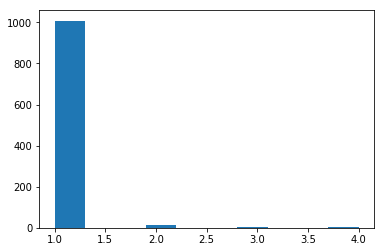

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.hist(df_total_liquidity_person["Company_Number"])

In [44]:
df_total_liquidity_person[df_total_liquidity_person["Company_Number"]==2]

,Shareholders_Name,Shareholders_Name_Normalized,Company_Equity,Company_Profile,Company_Number,Estimated_Total_Deal_Liquidity
54,Pedro Bartelle,bartelle pedro,"grendene s.a.(4.04%),azaleia s.a. vulcabras(4....","grendene s.a.,azaleia s.a. vulcabras",2.0,70.497360
198,Bnp Paribas Cardif,bnp cardif paribas,brasil cardif do e previdencia s.a. vida(99.99...,"brasil cardif do e previdencia s.a. vida,brasi...",2.0,1350.966037
209,Fernando Camara,camara fernando,"camara irmaos j s.a.(6.7%),anhanguera s.a. tel...","camara irmaos j s.a.,anhanguera s.a. televisao",2.0,4.553830
261,Ruben Feffer,feffer ruben,"celulose e papel s.a. suzano(4.24%),holding s....","celulose e papel s.a. suzano,holding s.a. suzano",2.0,1087.294046
314,Postalis,postalis,"engenharia fortes joao s.a.(6.37%),industriais...","engenharia fortes joao s.a.,industriais partic...",2.0,50.479719
452,Morgan Stanley,morgan stanley,"s.a. technos(8.17%),cesp companhia de energeti...","s.a. technos,cesp companhia de energetica paul...",2.0,50.083141
470,Jorge Feffer,feffer jorge,"celulose e papel s.a. suzano(4.2%),holding s.a...","celulose e papel s.a. suzano,holding s.a. suzano",2.0,1088.277577
528,Lapb Poland Fia,fia lapb poland,"cosan logistica s.a.(8.83%),cia coteminas de m...","cosan logistica s.a.,cia coteminas de minas no...",2.0,249.962288
549,Victor Adler,adler victor,"confab industrial s.a.(7.92%),eternit s.a.(10....","confab industrial s.a.,eternit s.a.",2.0,71.957779
709,Daniel Feffer,daniel feffer,"celulose e papel s.a. suzano(4.35%),holding s....","celulose e papel s.a. suzano,holding s.a. suzano",2.0,1098.112892


(array([ 933.,   51.,   17.,    5.,    4.,    4.,    2.,    2.,    3.,
           0.,    0.,    1.,    1.,    0.,    1.,    1.,    0.,    0.,
           1.,    0.,    0.,    0.,    0.,    0.,    1.,    0.,    1.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
           0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
      

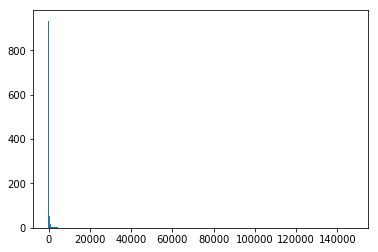

In [45]:
temp=df_total_liquidity_person["Estimated_Total_Deal_Liquidity"]
temp_min = temp.min()
temp_max = temp.max()
plt.figure()
plt.hist(temp, bins=np.arange(temp_min, temp_max+500, 500))

In [46]:
temp_max

147169.44625459565

### Dividends and Buyback
Dividends are tax-free

In [47]:
multiplier_div2ni = pd.read_excel('../Damodaran_data/divfcfeemerg.xls', skiprows=7)

In [48]:
industry_CIQ_Damod_sect_dict = defaultdict(list)
ave_div_ni_multiplier_dict = defaultdict(list)
for key in set(industry_Damodaran2CIQ["Capital IQ Definitions (11)"][:11]):
    # Restrict to first 11 elements in case some unknown elements in later position
    industry_CIQ_Damod_sect_dict[key] = list(set(
        industry_Damodaran2CIQ[industry_Damodaran2CIQ["Capital IQ Equivalent"]==key]["Damodaran (94)"]))
    print("CapIQ sector: %s;\n Damodaran's sector: %s" % (key, industry_CIQ_Damod_sect_dict[key]))
    div_multiplier = []
    for sub_sec in industry_CIQ_Damod_sect_dict[key]:
        div_multiplier.append(multiplier_div2ni[multiplier_div2ni["Industry name"]==sub_sec]["Cash Return as % of Net Income"].item())
    ave_div_ni_multiplier_dict[key] = np.nanmean(div_multiplier)

df_ave_div_ni_multiplier = pd.DataFrame.from_dict(ave_div_ni_multiplier_dict,orient='index')
df_ave_div_ni_multiplier.to_csv('./ave_divni_ratio_CIQ_sect.csv', 
                                header=['average over Damodaran\'s sectors-cash return as % of net income'], 
                                index_label=['CapitalIQ sectors'])
df_industry_CIQ_Damod_sect = pd.DataFrame([(sect, ','.join(subsect)) for sect, subsect in industry_CIQ_Damod_sect_dict.iteritems()])
df_industry_CIQ_Damod_sect.to_csv('./CIQ_Damod_sect.csv', header=['Capital IQ sectors', 'Damodaran\'s sectors'])

CapIQ sector: Industrials;
 Damodaran's sector: [u'Publishing & Newspapers', u'Farming/Agriculture', u'Shipbuilding & Marine', u'Transportation', u'Power', u'Electrical Equipment', u'Transportation (Railroads)', u'Office Equipment & Services', u'Engineering/Construction', u'Air Transport', u'Aerospace/Defense', u'Trucking', u'Construction Supplies', u'Environmental & Waste Services', u'Machinery']
CapIQ sector: Telecommunication Services;
 Damodaran's sector: [u'Telecom. Services']
CapIQ sector: Energy;
 Damodaran's sector: [u'Coal & Related Energy', u'Oil/Gas (Integrated)', u'Oil/Gas Distribution', u'Green & Renewable Energy', u'Oilfield Svcs/Equip.', u'Oil/Gas (Production and Exploration)']
CapIQ sector: Real Estate;
 Damodaran's sector: [u'Real Estate (Operations & Services)', u'R.E.I.T.', u'Real Estate (General/Diversified)', u'Real Estate (Development)']
CapIQ sector: Utilities;
 Damodaran's sector: [u'Utility (General)', u'Utility (Water)']
CapIQ sector: Consumer Staples;
 Damoda

In [49]:
# Add a column of estimated dividends
# estimated dividends = revenue * cash return as a % of NI * equity share

df_perc_owned["Estimated_Dividends_Liquidity"]=pd.Series([np.nan]*df_perc_owned.shape[0])

for idx, row in df_perc_owned.iterrows():
    comp_normalized = row["Company_Name_Normalized"]
    if (row["Shareholder_Is_Human"]
        and comp_normalized in CIQ_comp_name_set
        and comp_normalized not in CIQ_duplicate_comp_name_set):# Ensure company is unique in CapitalIQ
        total_revenue = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["TotalRevenue"].item()
        industry_sector = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["PrimarySector"].item()
        equity_share = row["PercentageOwned_Num"]
        if total_revenue and industry_sector and equity_share:
            #print(total_revenue, ave_ps_evs_multiplier_dict[industry_sector], tax_multiplier_dict[industry_sector])
            #print(idx, comp_normalized)
            df_perc_owned.at[idx, "Estimated_Dividends_Liquidity"]=(total_revenue*equity_share/100
                                                                    *ave_div_ni_multiplier_dict[industry_sector])

df_total_liquidity_person["Estimated_Total_Dividends_Liquidity"]=pd.Series([np.nan]*df_perc_owned.shape[0])

for idx, name in enumerate(df_total_liquidity_person["Shareholders_Name"]):
    comp_profile = df_perc_owned[df_perc_owned["Shareholders_Name"]==name]
    df_total_liquidity_person.at[idx, "Estimated_Total_Dividends_Liquidity"] = np.nansum(comp_profile["Estimated_Dividends_Liquidity"])

In [50]:
df_total_liquidity_person[:5]

,Shareholders_Name,Shareholders_Name_Normalized,Company_Equity,Company_Profile,Company_Number,Estimated_Total_Deal_Liquidity,Estimated_Total_Dividends_Liquidity
0,Giacomo Dalla Vecchia,dalla giacomo vecchia,cem lojas s.a.(23.3%),cem lojas s.a.,1.0,380.010160,172.001451
1,Gustavo Razzo Neto,gustavo neto razzo,ltd razzo(51.0%),ltd razzo,1.0,20.938537,5.168711
2,Guilherme Carvalho Tavares de Melo,carvalho de guilherme melo tavares,braganca participacoes s.a.(2.9%),braganca participacoes s.a.,1.0,43.546086,6.605441
3,Vicente Dos Anjos Dinis Ferraz,anjos dinis dos ferraz vicente,comercial de divena ltd veiculos(5.0%),comercial de divena ltd veiculos,1.0,8.935582,4.044452
4,Antonio Acir Rosa,acir antonio rosa,eletrosom s.a.(10.0%),eletrosom s.a.,1.0,25.035729,11.331754


### Stock Based Compensation
Stock are taxable

In [51]:
multiplier_sbc2s = pd.read_excel('../Damodaran_data/marginemerg.xls', skiprows=8)

In [52]:
industry_CIQ_Damod_sect_dict = defaultdict(list)
ave_sbc_sales_multiplier_dict = defaultdict(list)
for key in set(industry_Damodaran2CIQ["Capital IQ Definitions (11)"][:11]):
    # Restrict to first 11 elements in case some unknown elements in later position
    industry_CIQ_Damod_sect_dict[key] = list(set(
        industry_Damodaran2CIQ[industry_Damodaran2CIQ["Capital IQ Equivalent"]==key]["Damodaran (94)"]))
    # print("CapIQ sector: %s;\n Damodaran's sector: %s" % (key, industry_CIQ_Damod_sect_dict[key]))
    sbc_multiplier = []
    for sub_sec in industry_CIQ_Damod_sect_dict[key]:
        sbc_multiplier.append(multiplier_sbc2s[multiplier_sbc2s["Industry Name"]==sub_sec]["Stock-Based Compensation/Sales"].item())
    ave_sbc_sales_multiplier_dict[key] = np.nanmean(sbc_multiplier)

df_ave_sbc_sales_multiplier = pd.DataFrame.from_dict(ave_sbc_sales_multiplier_dict,orient='index')
df_ave_sbc_sales_multiplier.to_csv('./ave_sbcsales_ratio_CIQ_sect.csv', 
                                header=['average over Damodaran\'s sectors-Stock-Based Compensation/Sales'], 
                                index_label=['CapitalIQ sectors'])

In [53]:
# Add a column of estimated dividends
# estimated dividends = revenue * Stock-Based Compensation/Sales * (1-tax) * equity share

df_perc_owned["Estimated_Stock_Compensation_Liquidity"]=pd.Series([np.nan]*df_perc_owned.shape[0])

for idx, row in df_perc_owned.iterrows():
    comp_normalized = row["Company_Name_Normalized"]
    if (row["Shareholder_Is_Human"]
        and comp_normalized in CIQ_comp_name_set
        and comp_normalized not in CIQ_duplicate_comp_name_set):# Ensure company is unique in CapitalIQ
        total_revenue = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["TotalRevenue"].item()
        industry_sector = df_comp_info[df_comp_info["Company_Name_Normalized"]==comp_normalized]["PrimarySector"].item()
        equity_share = row["PercentageOwned_Num"]
        if total_revenue and industry_sector and equity_share:
            #print(total_revenue, ave_ps_evs_multiplier_dict[industry_sector], tax_multiplier_dict[industry_sector])
            #print(idx, comp_normalized)
            df_perc_owned.at[idx, "Estimated_Stock_Compensation_Liquidity"]=(total_revenue*equity_share/100
                                                                    *ave_div_ni_multiplier_dict[industry_sector]
                                                                    *(1-tax_multiplier_dict[industry_sector]))

df_total_liquidity_person["Estimated_Total_Stock_Compensation_Liquidity"]=pd.Series([np.nan]*df_perc_owned.shape[0])

for idx, name in enumerate(df_total_liquidity_person["Shareholders_Name"]):
    comp_profile = df_perc_owned[df_perc_owned["Shareholders_Name"]==name]
    df_total_liquidity_person.at[idx, "Estimated_Total_Stock_Compensation_Liquidity"] = np.nansum(
        comp_profile["Estimated_Stock_Compensation_Liquidity"])

In [54]:
df_total_liquidity_person[:5]

,Shareholders_Name,Shareholders_Name_Normalized,Company_Equity,Company_Profile,Company_Number,Estimated_Total_Deal_Liquidity,Estimated_Total_Dividends_Liquidity,Estimated_Total_Stock_Compensation_Liquidity
0,Giacomo Dalla Vecchia,dalla giacomo vecchia,cem lojas s.a.(23.3%),cem lojas s.a.,1.0,380.010160,172.001451,135.340725
1,Gustavo Razzo Neto,gustavo neto razzo,ltd razzo(51.0%),ltd razzo,1.0,20.938537,5.168711,3.888043
2,Guilherme Carvalho Tavares de Melo,carvalho de guilherme melo tavares,braganca participacoes s.a.(2.9%),braganca participacoes s.a.,1.0,43.546086,6.605441,5.294780
3,Vicente Dos Anjos Dinis Ferraz,anjos dinis dos ferraz vicente,comercial de divena ltd veiculos(5.0%),comercial de divena ltd veiculos,1.0,8.935582,4.044452,3.182410
4,Antonio Acir Rosa,acir antonio rosa,eletrosom s.a.(10.0%),eletrosom s.a.,1.0,25.035729,11.331754,8.916482


In [67]:
# The default encoding is 'ascii' which is not correct.
# When I tried 'latin1', it works. There some breif explanation about encoding.
# https://stackoverflow.com/questions/5387895/unicodeencodeerror-ascii-codec-cant-encode-character-u-u2013-in-position-3
# (Common ones are ISO-8859-1, most commonly known as Latin-1, which contains the 256 first code points; UTF-8, 
# which can encode all code-points by using variable length encoding, CP1252 that is common on Windows, 
# and various Chinese and Japanese encodings.)
# 'utf8' doesn't work. 'utf16' works but require twice space as 'latin-1'
df_total_liquidity_person.to_csv('./total_liquidity_person_CIQ_EMIS_20180306.csv',encoding='utf16')

### Projected Wealth Growth